# Synthetic Experiment Reproduction (Google Colab Version)
This notebook guide you through the reproduction of the synthetic hidden subgroup discovery experiment.

**Hardware Recommendation:** Ensure you are using a GPU runtime (Runtime > Change runtime type > T4 GPU).

## 1. Setup Environment

### 1.1 Install Specialized Research Tools
We need to downgrade NumPy to 1.x for research tool compatibility. Since Colab 2024 uses Python 3.12, we use specific versions to avoid binary incompatibility.

In [1]:
# 1. Clean environment: remove incompatible versions
!pip uninstall -y numpy pandas

# 2. Install stable binaries for Python 3.12 bridge
%pip install "numpy==1.26.4" "pandas>=2.1.1" --quiet

# 3. Install CLIP and HazyResearch Discovery Tools
%pip install git+https://github.com/openai/CLIP.git --quiet
%pip install git+https://github.com/hazyresearch/meerkat.git --quiet
%pip install "domino[clip] @ git+https://github.com/hazyresearch/domino.git" --quiet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 131.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatib

### ACTION REQUIRED: RESTART RUNTIME
After the cell above finishes, you **MUST** click **Runtime > Restart session** in the menu above.

Failure to do this will result in a `ValueError: numpy.dtype size changed` error because the old versions are still in memory.

In [1]:
import torch
import numpy as np
import pandas as pd
import meerkat as mk
import domino

print("✅ Device:", "CUDA Available" if torch.cuda.is_available() else "NO GPU FOUND")
print(f"✅ NumPy version: {np.__version__} (Should be 1.26.4)")
print(f"✅ Pandas version: {pd.__version__}")
print("✅ All research tools imported successfully!")

if not np.__version__.startswith("1.26"):
    print("\nWARNING: Your NumPy version is still wrong. Did you forget to 'Restart session'?")

✅ Device: CUDA Available
✅ NumPy version: 1.26.4 (Should be 1.26.4)
✅ Pandas version: 3.0.0
✅ All research tools imported successfully!


### 1.2 Clone github repo

In [2]:
# Clone repo
!git clone https://github.com/stu-rdy/uncover_hidden_stratification.git
%cd uncover_hidden_stratification/experiments/synthetic

Cloning into 'uncover_hidden_stratification'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (444/444), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 444 (delta 274), reused 442 (delta 272), pack-reused 0 (from 0)
Receiving objects: 100% (444/444), 2.80 MiB | 5.75 MiB/s, done.
Resolving deltas: 100% (274/274), done.
/content/uncover_hidden_stratification/experiments/synthetic


In [3]:
import os
print("Current directory:", os.getcwd())
os.makedirs("../../results", exist_ok=True)

Current directory: /content/uncover_hidden_stratification/experiments/synthetic


In [ ]:
!pip install -r /content/uncover_hidden_stratication/requirements.txt --quiet

## 3. Run Reproduction Pipeline
We use `configs/colab_config.yaml` for standardized runs on NVIDIA T4 GPUs.

In [5]:
CONFIG = "configs/colab_config.yaml"

---

## Reproduction pipeline

This will download the Imagenette Dataset (342 MB) and start the preprocessing stage.

In [6]:
# 3.1 Data Preparation
!python scripts/1_setup_data.py
!python scripts/2_generate_synthetic.py --config {CONFIG} --no-wandb

100% 342M/342M [00:25<00:00, 13.4MiB/s]
Extracting...
Data setup complete.
Processing images: 100% 13394/13394 [03:46<00:00, 59.08it/s]

Dataset statistics:
  Train: 9469 images, artifact rate: 0.123
  Val:   1934 images, artifact rate: 0.528
  Test:  1991 images, artifact rate: 0.508
  train: 9469 images, hidden rate: 0.123, known rate: 0.250
  val: 1934 images, hidden rate: 0.528, known rate: 0.486
  test: 1991 images, hidden rate: 0.508, known rate: 0.508
Synthetic dataset generation complete.


In [7]:
# 3.2 Model Training (includes Early Stopping on Worst-Group Accuracy)
!python scripts/3_train_model.py --config {CONFIG} --no-wandb

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 242MB/s]
Epoch 0: Loss 0.7715, Train Acc 0.7879, Val Acc 0.8687, WG Acc 0.5909
  --> Best worst_group_acc improved to 0.5909. Saving model.
Epoch 1: Loss 0.2376, Train Acc 0.9343, Val Acc 0.8973, WG Acc 0.5227
  --> worst_group_acc did not improve. Patience: 1/5
Epoch 2: Loss 0.1541, Train Acc 0.9591, Val Acc 0.9156, WG Acc 0.6809
  --> Best worst_group_acc improved to 0.6809. Saving model.
Epoch 3: Loss 0.1035, Train Acc 0.9769, Val Acc 0.9228, WG Acc 0.7234
  --> Best worst_group_acc improved to 0.7234. Saving model.
Epoch 4: Loss 0.0723, Train Acc 0.9864, Val Acc 0.9223, WG Acc 0.7234
  --> worst_group_acc did not improve. Patience: 1/5
Epoch 5: Loss 0.0534, Train Acc 0.9913, Val Acc 0.9266, WG Acc 0.7463
  --> Best worst_group_acc improved to 0.7463. Saving model.
Epoch 6: Loss 0.0361, Train Acc 0.9960

In [8]:
# 3.3 Discovery Analysis
!python scripts/4_extract_features.py --config {CONFIG}
!python scripts/5_run_analysis.py --config {CONFIG} --no-wandb

Using device: cuda
Extracting features for train...
100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 165MiB/s]
100% 148/148 [01:02<00:00,  2.35it/s]
Saved to /content/uncover_hidden_stratification/data/synthetic_imagenette/train_embeddings.mk
Extracting features for val...
100% 31/31 [00:12<00:00,  2.43it/s]
Saved to /content/uncover_hidden_stratification/data/synthetic_imagenette/val_embeddings.mk
Extracting features for test...
100% 32/32 [00:13<00:00,  2.44it/s]
Saved to /content/uncover_hidden_stratification/data/synthetic_imagenette/test_embeddings.mk
Loading data...
Running Domino with 15 slices and weight 10.0...
 25% 25/100 [00:00<00:00, 79.75it/s]

=== Validation Set Analysis ===
    slice  size  dom_class  ...  known_rate  accuracy  split
0       0    27          0  ...    0.888889  0.703704    val
1       1    53          3  ...    0.339623  0.867925    val
2       2    37          5  ...    0.567568  0.945946    val
3       3    97          4  ...    0

## 4. Results Visualization

In [12]:
import pandas as pd
try:
    results = pd.read_csv('../../results/synthetic_analysis.csv')
    print("Found Discovered Slices:")
    display(results.head(30))
except FileNotFoundError:
    print("Results file not found. Check if scripts 4 and 5 completed successfully.")

Found Discovered Slices:


,slice,size,dom_class,dom_class_perc,hidden_rate,known_rate,accuracy,split
0,0,27,0,0.555556,1.000000,0.888889,0.703704,val
1,1,53,3,0.905660,1.000000,0.339623,0.867925,val
2,2,37,5,0.945946,1.000000,0.567568,0.945946,val
3,3,97,4,0.536082,0.226804,0.505155,0.876289,val
4,4,60,0,0.700000,0.700000,0.650000,0.850000,val
5,5,215,3,0.553488,0.306977,0.413953,0.879070,val
6,6,232,9,0.788793,0.521552,0.487069,0.913793,val
7,7,166,6,0.813253,0.728916,0.518072,0.975904,val
8,8,162,2,0.962963,0.592593,0.493827,0.975309,val
9,9,156,1,1.000000,0.506410,0.512821,0.993590,val


### 4.1 Discovery Visualizations

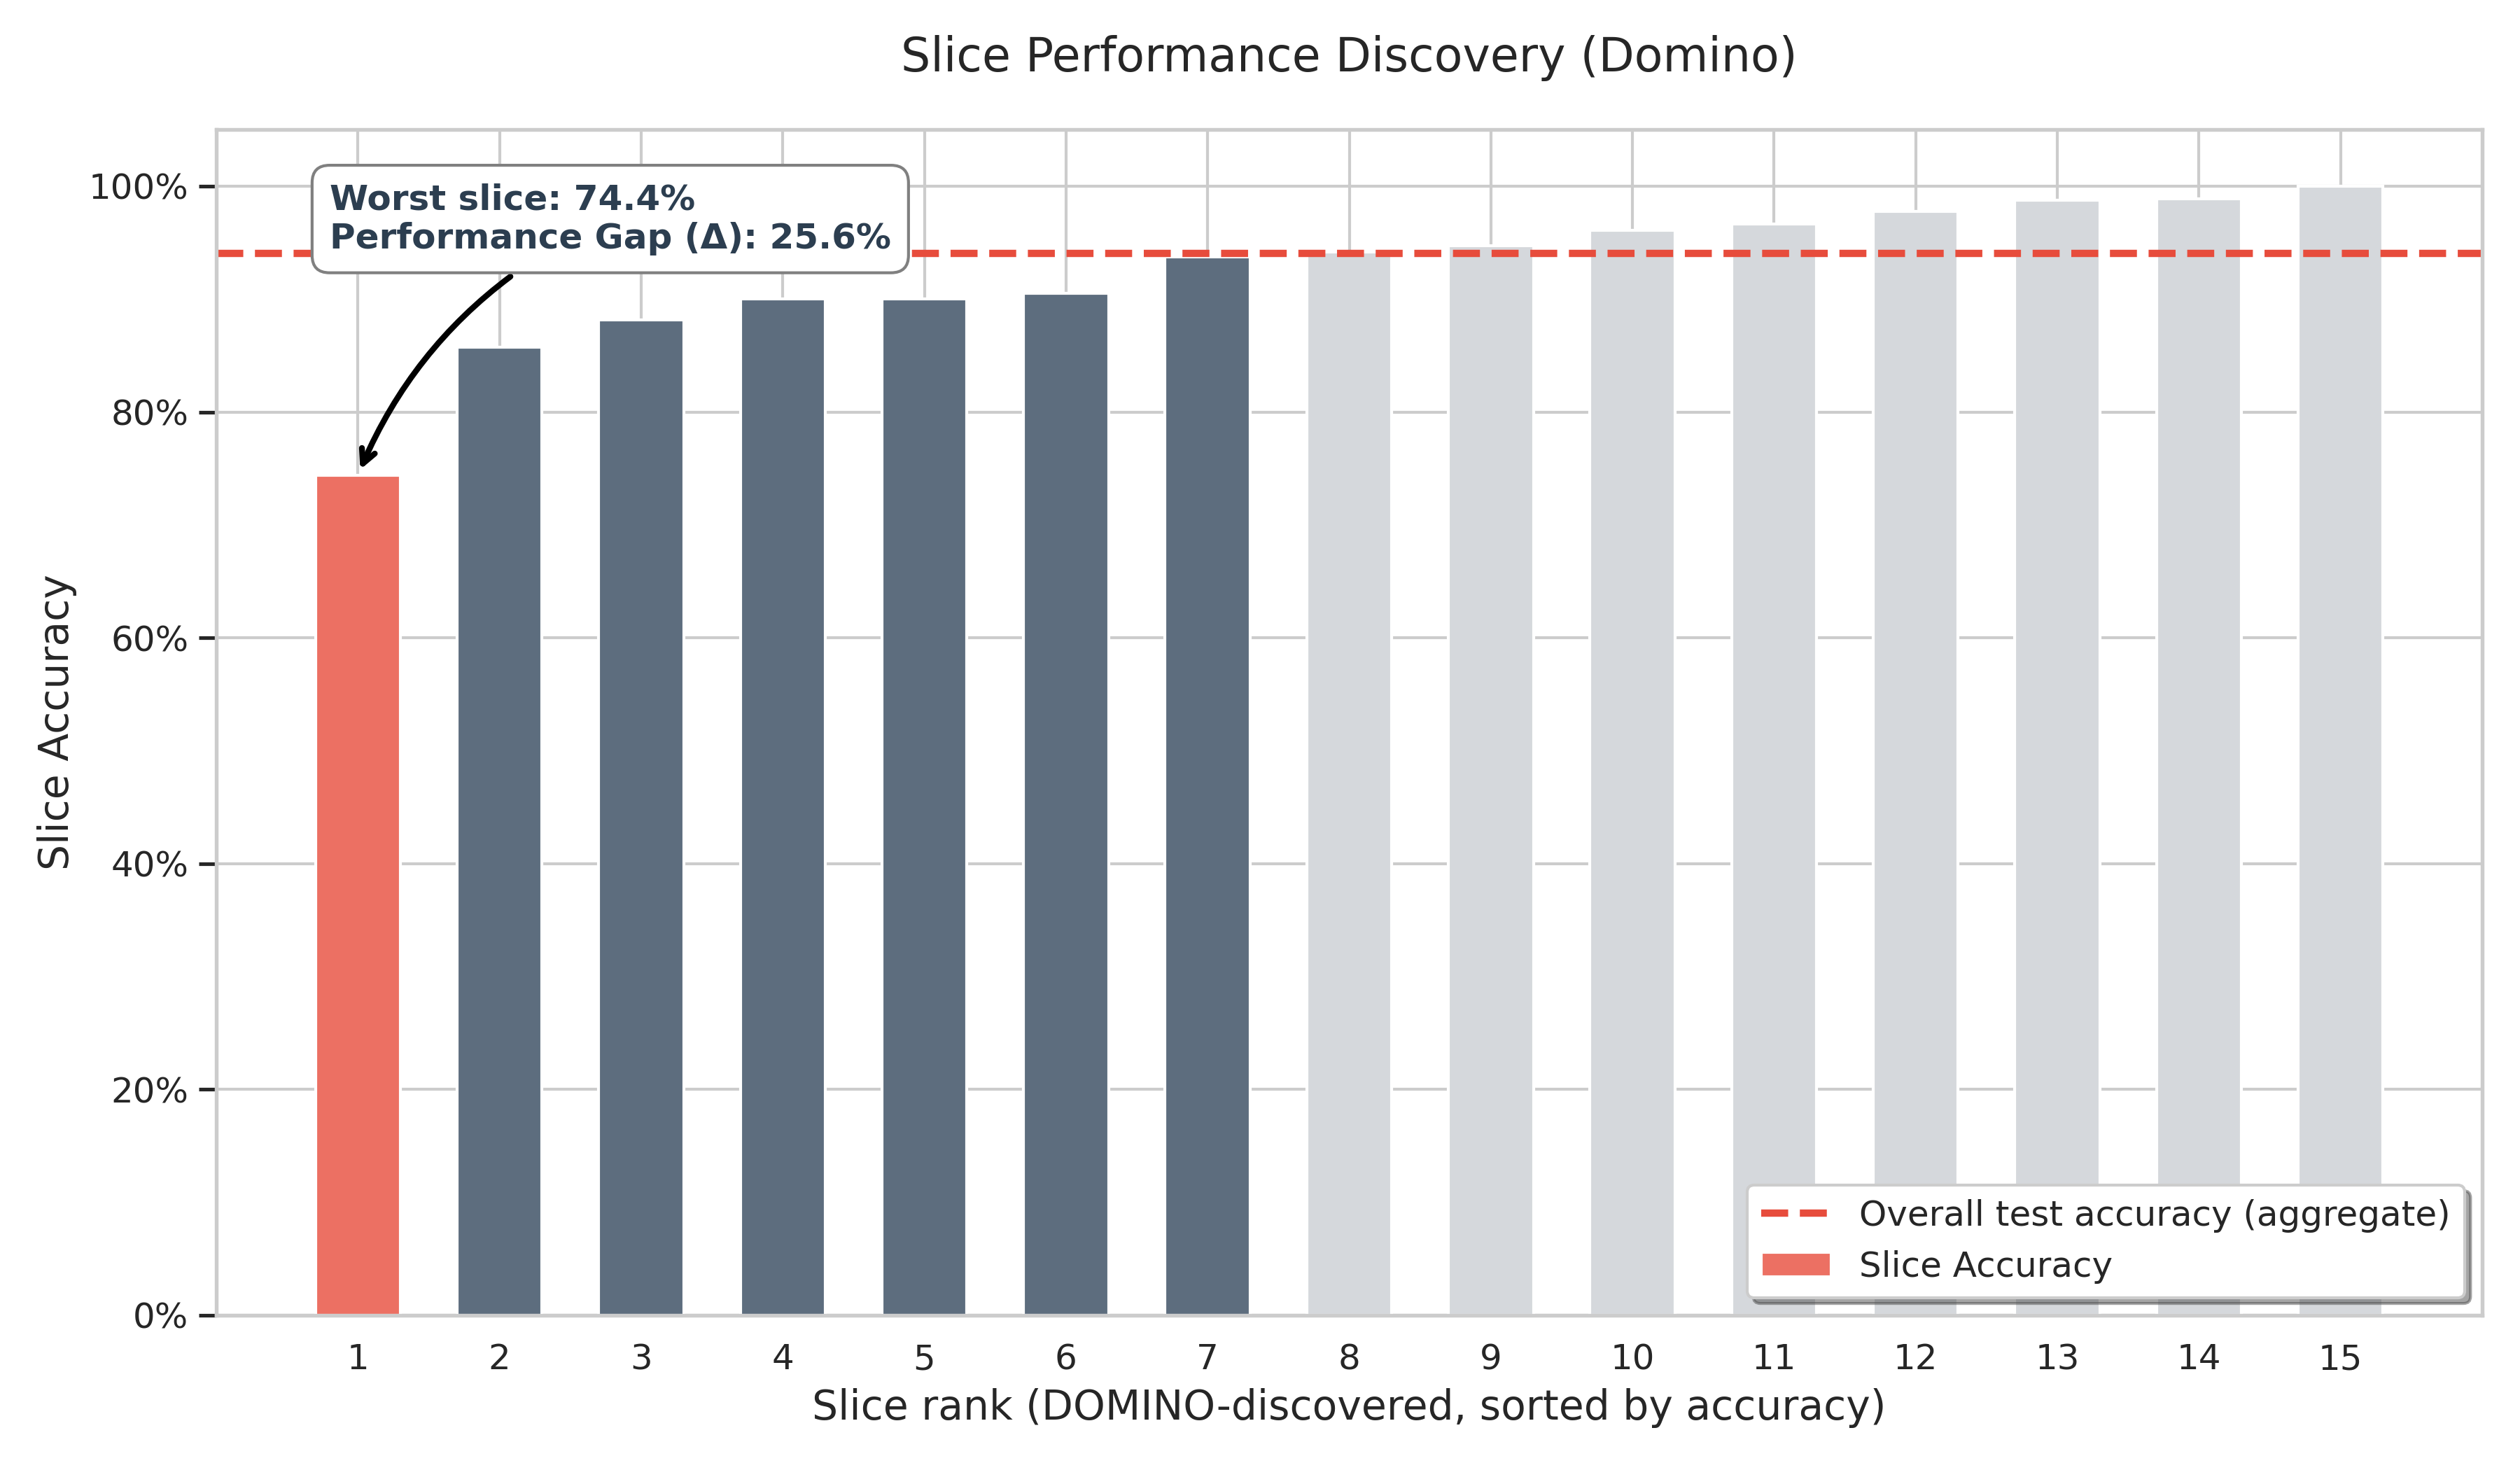

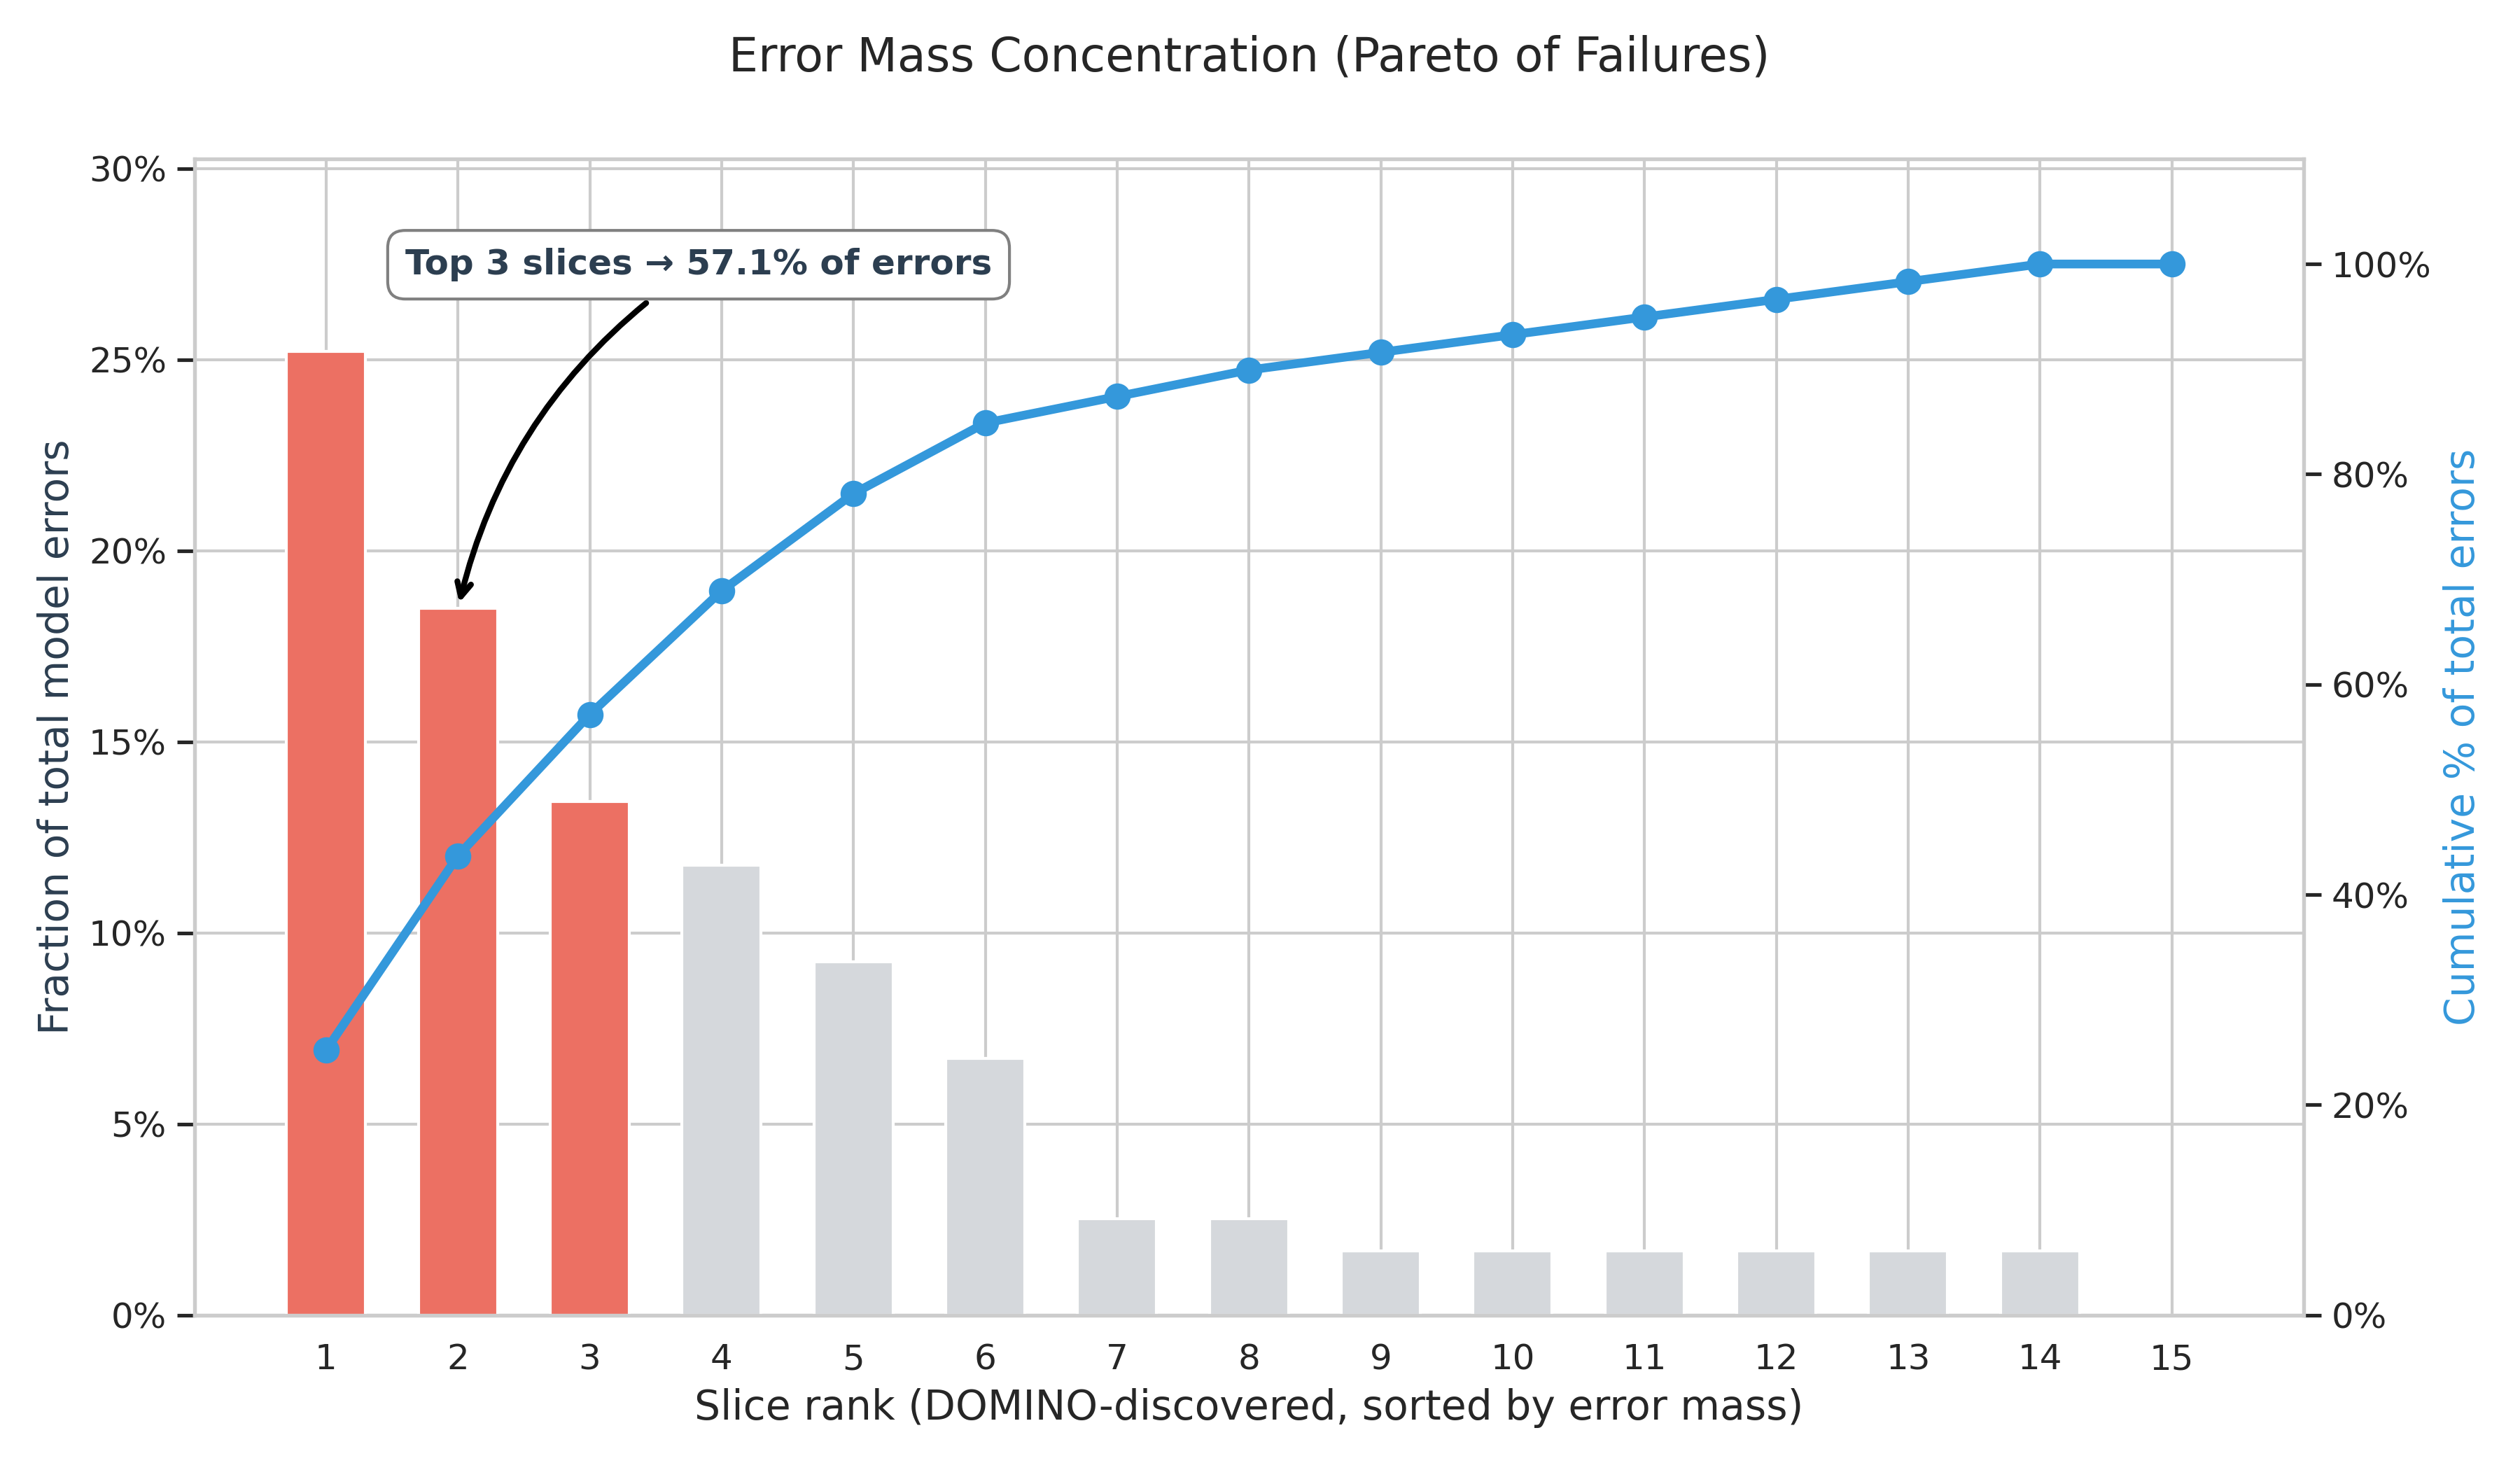

In [10]:
from IPython.display import Image, display
import os

plot_dir = '../../results/plots'
if os.path.exists(plot_dir):
    display(Image(filename=os.path.join(plot_dir, 'slice_analysis.png')))
    display(Image(filename=os.path.join(plot_dir, 'error_concentration.png')))
else:
    print("Plot directory not found.")

### 4.2 Example Images for Top Error Slices
These images are automatically extracted based on their contribution to the total error mass.

In [ ]:
import os
from IPython.display import Image, display, Markdown

example_dir = '../../results/slice_examples'
if os.path.exists(example_dir):
    # Read the summary if it exists
    summary_path = os.path.join(example_dir, "extraction_summary.md")
    if os.path.exists(summary_path):
        with open(summary_path, 'r') as f:
            display(Markdown(f.read()))

    # List and display images per slice
    for slice_folder in sorted(os.listdir(example_dir)):
        slice_path = os.path.join(example_dir, slice_folder)
        if os.path.isdir(slice_path):
            display(Markdown(f"#### Images for {slice_folder}"))
            image_files = [f for f in os.listdir(slice_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            for img_file in sorted(image_files):
                img_path = os.path.join(slice_path, img_file)
                display(Markdown(f"**{img_file}**"))
                display(Image(filename=img_path, width=300))
else:
    print("Example images directory not found.")